In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
os.chdir("/content/gdrive/MyDrive/DISSERTATION")
print(os.listdir())

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
['simple_hilbert.py', '__pycache__', 'Flowpast', 'MeshCNN', 'cache', 'fpc_000.npz (Unzipped Files)', 'Advection_of_a_block_over_structured_mesh.ipynb', 'fpc2.obj', 'Diss.ipynb', 'csv_data', 'fpc3.obj', 'TENS', 'Diss2.ipynb', 'AE with FC.ipynb', 'Diss3.ipynb', 'Compressed.obj', 'CAE_on_structured_mesh.ipynb', 'PyTorch Geometric attempt 2', 'MoreChannels.ipynb', 'animation', 'original_simulation.mp4', 'Compress.ipynb', 'Copy of MoreChannels.ipynb', 'OLDMULTIPLE', 'MultipleCurves', 'Cleanedd.obj', 'Cleaned2.obj', 'Cleaned3.obj', 'Cleaned4.obj', 'Cleaned5.obj', 'Cleaned6.obj', 'figure.png', 'Cleaned7.obj', 'Cleaned8.obj', 'Cleaned9.obj', 'popped.obj', 'lessee.obj', 'Compress2.ipynb', 'GCAE.ipynb', 'New', 'Presentation.gslides', 'GCAE2.ipynb', 'Someboundary', 'Someboundary.obj']


In [2]:
#Importing a bunch of stuff from MeshCNN
os.chdir("./MeshCNN")
print(os.listdir())
import models
import options.train_options
os.chdir("./util")
import mesh_viewer
os.chdir("..")
os.chdir("./models")
import networks
os.chdir("./layers")
import mesh
import mesh_pool
import mesh_unpool
import mesh_union
os.chdir("../../../")

['.git', '.gitignore', '.travis.yml', 'LICENSE', 'README.md', 'data', 'docs', 'environment.yml', 'models', 'options', 'scripts', 'test.py', 'train.py', 'util', 'cache']


In [3]:
#Importing a bunch more libraries
import numpy as np
import matplotlib.pyplot as plt
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision
from torch.utils.data import DataLoader
from matplotlib import animation
import sys
import progressbar

In [4]:
!pip install pycm livelossplot
%pylab inline
from livelossplot import PlotLosses

Populating the interactive namespace from numpy and matplotlib


In [5]:
import random 
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cuda'  # Set out device to GPU

print('Cuda installed, running on GPU!')  # print sentence

Cuda installed, running on GPU!


In [6]:
def loadfpc(index):
  vels = open("./csv_data/data_"+ str(index) + ".csv")
  velocities = np.loadtxt(vels, delimiter=",")[:,3:5]
  EdgeFeatures = np.array([[(velocities[edge[0]][0]+velocities[edge[1]][0])/2,(velocities[edge[0]][1]+velocities[edge[1]][1])/2] for edge in fpcmesh.edges])
  velx = torch.Tensor([[EdgeFeatures[:,0],EdgeFeatures[:,1]]])
  return velx

In [7]:
def pushedge(mesh, i,vertextovert,points,edges):
  v1 = mesh.edges[i][0]
  v2 = mesh.edges[i][1]

  if v1 not in vertextovert.keys():
    vertextovert[v1] = len(vertextovert)
    points.append(mesh.vs[v1][:2])
  if v2 not in vertextovert.keys():
    vertextovert[v2] = len(vertextovert)
    points.append(mesh.vs[v2][:2])
  if [vertextovert[v1],vertextovert[v2]] not in edges:
    edges.append([vertextovert[v1],vertextovert[v2]])

def sketch(mesh, i, depth):
  points = [] #numpy.array([1,2],[4,5],[2,7],[3,9],[9,2])
  edges = [] #numpy.array([0,1],[3,4],[3,2],[2,4])
  vertextovert = {}

  pushedge(mesh,i,vertextovert,points,edges)
  
  tocheck = [[i]]
  for dp in range(depth):
    tocheck.append([])
    for tc in tocheck[dp]:
      for edge in mesh.gemm_edges[tc]:
        if (edge !=-1):
          tocheck[dp+1].append(edge)
          pushedge(mesh,edge,vertextovert,points,edges)
  print(points, edges, vertextovert)

  points = np.array(points)
  edges = np.array(edges)
  x = points[:,0].flatten()
  y = points[:,1].flatten()
  plt.plot(x[edges[0].T], y[edges[0].T], 'b-') # Edges
  plt.plot(x[edges[1:].T], y[edges[1:].T], 'y-') # Edges
  plt.plot(x, y, 'ro') # Points

In [8]:
#Opt class from MeshCNN, to create a "Mesh" class you need an option class for data augmentation purposes, hard to get mesh loading to work otherwise
class opt:
  num_aug = 1

In [9]:
#Creating my flow past cylinder mesh
fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
fpcmesh.init_history()

In [10]:
data = loadfpc(20)

In [11]:
pooloperator = mesh_pool.MeshPool(5000)

In [12]:
result = pooloperator(data,[fpcmesh])

collapsing edge 9364
collapsed edge 9364
collapsing edge 4340
collapsed edge 4340
collapsing edge 6636
collapsed edge 6636
collapsing edge 6494
collapsed edge 6494
collapsing edge 6897
collapsed edge 6897
collapsing edge 10000
collapsed edge 10000
collapsing edge 9185
collapsed edge 9185
collapsing edge 10304
collapsed edge 10304
collapsing edge 8418
collapsed edge 8418
collapsing edge 6634
collapsed edge 6634
collapsing edge 8417
collapsed edge 8417
collapsing edge 9763
collapsed edge 9763
collapsing edge 9817
collapsed edge 9817
collapsing edge 9999
collapsed edge 9999
collapsing edge 8447
collapsed edge 8447
collapsing edge 9362
collapsed edge 9362
collapsing edge 9360
collapsed edge 9360
collapsing edge 9184
collapsed edge 9184
collapsing edge 6896
collapsed edge 6896
collapsing edge 8441
collapsed edge 8441
collapsing edge 6971
collapsed edge 6971
collapsing edge 6855
collapsed edge 6855
collapsing edge 10251
collapsed edge 10251
collapsing edge 7093
collapsed edge 7093
collapsing

In [13]:
edges = []
for i in range(len(fpcmesh.gemm_edges)):
  if -1 in fpcmesh.gemm_edges[i]:
    edges.append(i)
print(edges)

[1, 2, 6, 7, 10, 11, 15, 17, 18, 20, 23, 28, 31, 43, 50, 62, 72, 125, 132, 134, 157, 163, 176, 177, 184, 185, 188, 191, 193, 194, 244, 293, 314, 318, 320, 324, 327, 330, 332, 334, 337, 339, 342, 345, 347, 349, 350, 353, 355, 356, 358, 362, 365, 367, 369, 374, 376, 378, 382, 384, 386, 396, 401, 423, 437, 439, 450, 783, 835, 903, 1082, 1084, 1150, 1172, 1175, 1224, 1241, 1285, 1319, 1333, 1350, 1366, 1420, 1445, 1465, 1496, 1506, 1551, 1564, 1600, 1605, 1616, 1632, 1657, 1718, 1720, 1722, 1730, 1737, 1758, 1809, 1817, 1823, 1927, 1959, 1988, 2026, 2040, 2116, 2122, 2133, 2135, 2136, 2293, 2653, 2658, 2676, 2701, 2705, 2713, 2715, 2729, 2741, 2743, 2745, 2753, 2778, 2785, 2787, 2790, 2792, 2802, 2803, 2807, 2811, 2818, 2825, 2829, 2833, 2837, 2845, 2847, 2850, 2852, 2855, 2860, 2864, 2871, 2876, 2881, 2886, 2895, 2901, 2995, 3014, 3057, 3065, 3072, 3144, 3146, 3157, 3270, 3273, 3277, 3279, 3282, 3285, 3287, 3289, 3333, 3351, 3373, 3392, 3416, 3453, 3461, 3499, 3521, 3567, 3594, 3638, 3783

[array([1.33107966, 0.41      ]), array([1.36540574, 0.41      ]), array([1.13365341, 0.37660036]), array([1.38118641, 0.34904743]), array([1.29736875, 0.41      ]), array([1.4003582, 0.41     ]), array([1.29743403, 0.27592521]), array([1.26426197, 0.41      ]), array([1.43594846, 0.41      ]), array([1.39349957, 0.25465536]), array([1.21979619, 0.30265801]), array([1.2317485, 0.41     ]), array([1.47218819, 0.41      ]), array([1.58371554, 0.33916974]), array([1.1326401 , 0.29845506]), array([1.1998177, 0.41     ])] [[0, 1], [1, 2], [0, 2], [1, 3], [3, 2], [4, 2], [4, 0], [1, 5], [5, 3], [3, 6], [6, 2], [7, 2], [7, 4], [5, 8], [8, 3], [9, 3], [9, 6], [10, 6], [10, 2], [11, 2], [11, 7], [8, 12], [12, 3], [13, 3], [13, 9], [14, 9], [14, 6], [14, 10], [2, 14], [15, 2], [15, 11]] {175: 0, 176: 1, 2839: 2, 519: 3, 174: 4, 177: 5, 2020: 6, 173: 7, 178: 8, 1818: 9, 1406: 10, 172: 11, 179: 12, 2398: 13, 1350: 14, 171: 15}


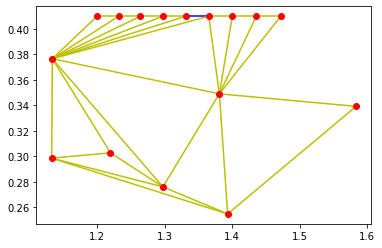

In [14]:
sketch(fpcmesh,7,5)

In [15]:
edgegroups = mesh_union.MeshUnion(fpcmesh.edges_count, torch.Tensor(fpcmesh.features).device)

In [16]:
mask = np.ones(fpcmesh.edges_count, dtype=np.bool)

In [17]:
# pooloperator._MeshPool__pool_side(fpcmesh,7,mask,edgegroups, 0)
# fpcmesh.merge_vertices(7)
# mask[7] = False
# pooloperator._MeshPool__remove_group(fpcmesh, edgegroups, 7)
# fpcmesh.edges_count -= 1

In [18]:
fpcmesh.clean(mask, edgegroups)

In [19]:
print(fpcmesh.edges[7])

[175 176]


[array([1.33107966, 0.41      ]), array([1.36540574, 0.41      ]), array([1.13365341, 0.37660036]), array([1.38118641, 0.34904743]), array([1.29736875, 0.41      ]), array([1.4003582, 0.41     ]), array([1.29743403, 0.27592521]), array([1.26426197, 0.41      ]), array([1.43594846, 0.41      ]), array([1.39349957, 0.25465536]), array([1.21979619, 0.30265801]), array([1.2317485, 0.41     ]), array([1.47218819, 0.41      ]), array([1.58371554, 0.33916974]), array([1.1326401 , 0.29845506]), array([1.1998177, 0.41     ])] [[0, 1], [1, 2], [0, 2], [1, 3], [3, 2], [4, 2], [4, 0], [1, 5], [5, 3], [3, 6], [6, 2], [7, 2], [7, 4], [5, 8], [8, 3], [9, 3], [9, 6], [10, 6], [10, 2], [11, 2], [11, 7], [8, 12], [12, 3], [13, 3], [13, 9], [14, 9], [14, 6], [14, 10], [2, 14], [15, 2], [15, 11]] {175: 0, 176: 1, 2839: 2, 519: 3, 174: 4, 177: 5, 2020: 6, 173: 7, 178: 8, 1818: 9, 1406: 10, 172: 11, 179: 12, 2398: 13, 1350: 14, 171: 15}


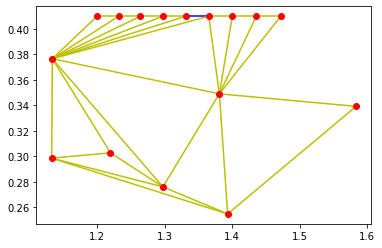

In [20]:
sketch(fpcmesh,7,5)

In [21]:
# fpcmesh.clean(mask, edgegroups)
# fe = edgegroups.rebuild_features(torch.Tensor(fpcmesh.features), mask, 10419)
# fpcmesh.features = fe.numpy()

In [22]:
# nocv = []
# for i in range(len(fpcmesh.v_mask)):
#   if -1 in fpcmesh.gemm_edges[fpcmesh.ve[i]]:
#     vert = fpcmesh.vs[i][:2]
#     if vert[0]!= 0 and vert[1]!= 0 and vert[0]!= 2.2 and vert[1]!= 0.41:
#       nocv.append(vert)

In [23]:
# def navigator(fpcmesh, ed):
#   for i in fpcmesh.ve[fpcmesh.edges[ed][0]]:
#     if i in edges:
#       print(i)
#   for i in fpcmesh.ve[fpcmesh.edges[ed][1]]:
#     if i in edges:
#       print(i)

In [24]:
# navigator(fpcmesh,8445)

In [25]:
pooloperator2 = mesh_pool.MeshPool(2000)

In [26]:
result2 = pooloperator2(result,[fpcmesh])

collapsing edge 4211
collapsed edge 4211
collapsing edge 3302
collapsed edge 3302
collapsing edge 3361
collapsed edge 3361
collapsing edge 2157
collapsed edge 2157
collapsing edge 4010
collapsed edge 4010
collapsing edge 4004
collapsed edge 4004
collapsing edge 4469
collapsed edge 4469
collapsing edge 4696
collapsed edge 4696
collapsing edge 3349
collapsed edge 3349
collapsing edge 4659
collapsed edge 4659
collapsing edge 4007
collapsed edge 4007
collapsing edge 3311
collapsed edge 3311
collapsing edge 4017
collapsed edge 4017
collapsing edge 1691
collapsed edge 1691
collapsing edge 698
collapsed edge 698
collapsing edge 3348
collapsed edge 3348
collapsing edge 1331
collapsed edge 1331
collapsing edge 1562
collapsed edge 1562
collapsing edge 3016
collapsed edge 3016
collapsing edge 4025
collapsed edge 4025
collapsing edge 645
collapsed edge 645
collapsing edge 842
collapsed edge 842
collapsing edge 627
collapsed edge 627
collapsing edge 4880
collapsed edge 4880
collapsing edge 582
coll

In [27]:
pooloperator3 = mesh_pool.MeshPool(750)
result3 = pooloperator3(result2,[fpcmesh])

collapsing edge 340
collapsed edge 340
collapsing edge 1537
collapsed edge 1537
collapsing edge 1818
collapsed edge 1818
collapsing edge 398
collapsed edge 398
collapsing edge 687
collapsed edge 687
collapsing edge 488
collapsed edge 488
collapsing edge 1038
collapsed edge 1038
collapsing edge 387
collapsed edge 387
collapsing edge 1211
collapsed edge 1211
collapsing edge 63
collapsed edge 63
collapsing edge 317
collapsed edge 317
collapsing edge 62
collapsed edge 62
collapsing edge 1867
collapsed edge 1867
collapsing edge 1329
collapsed edge 1329
collapsing edge 51
collapsed edge 51
collapsing edge 1233
collapsed edge 1233
collapsing edge 1202
collapsed edge 1202
collapsing edge 943
collapsed edge 943
collapsing edge 1152
collapsed edge 1152
collapsing edge 417
collapsed edge 417
collapsing edge 1861
collapsed edge 1861
collapsing edge 1224
collapsed edge 1224
collapsing edge 1872
collapsed edge 1872
collapsing edge 778
collapsed edge 778
collapsing edge 427
collapsed edge 427
collaps

In [28]:
fpcmesh.export("Someboundary.obj")

In [29]:
print(

SyntaxError: ignored

In [30]:
pooloperator4 = mesh_pool.MeshPool(700)
result4 = pooloperator4(result3,[fpcmesh])

collapsing boundary edge 582
collapsed boundary edge 582
collapsing boundary edge 494
collapsed boundary edge 494
collapsing boundary edge 544
collapsed boundary edge 544
collapsing boundary edge 643
collapsed boundary edge 643
collapsing boundary edge 462
collapsed boundary edge 462
collapsing boundary edge 658
collapsed boundary edge 658
collapsing boundary edge 656
collapsed boundary edge 656
collapsing boundary edge 444
collapsed boundary edge 444
collapsing boundary edge 583
collapsed boundary edge 583
collapsing boundary edge 536
collapsed boundary edge 536
collapsing boundary edge 323
collapsed boundary edge 323
collapsing boundary edge 719
collapsed boundary edge 719
collapsing boundary edge 673
collapsed boundary edge 673
collapsing boundary edge 607
collapsed boundary edge 607
collapsing boundary edge 546
collapsed boundary edge 546
collapsing boundary edge 80
collapsed boundary edge 80
collapsing boundary edge 307
collapsed boundary edge 307
collapsing boundary edge 499
coll

ValueError: ignored

In [ ]:
pooloperator5 = mesh_pool.MeshPool(650)
result5 = pooloperator5(result4,[fpcmesh])

In [ ]:
# def findcyl(mesh):
#   nocv = []
#   for i in range(len(mesh.v_mask)):
#     if -1 in mesh.gemm_edges[mesh.ve[i]]:
#       vert = mesh.vs[i][:2]
#       if vert[0]!= 0 and vert[1]!= 0 and vert[0]!= 2.2 and vert[1]!= 0.41:
#         nocv.append(vert)
#   return np.array(nocv)

In [ ]:
# print(findcyl(fpcmesh))

In [ ]:
edge_groups = mesh_union.MeshUnion(fpcmesh.edges_count, torch.Tensor(fpcmesh.features).device)

In [ ]:
def groupsizetot(group):
  return group.sum().item()-group.size()[0]

In [ ]:
groups = fpcmesh.history_data["groups"]

In [ ]:
print(groups[0][100].sum())

In [ ]:
groupsizetot(groups[0])

In [ ]:
fpcmesh.get_occurrences()

In [ ]:
edge_groups.get_group(0)

In [ ]:
edge_groups = mesh_union.MeshUnion(fpcmesh.edges_count, data.device)
mask = np.ones(fpcmesh.edges_count, dtype=np.bool)

In [ ]:
for i in range(fpcmesh.edges_count):
  if not pooloperator.has_boundaries(fpcmesh,i):
    print(pooloperator._MeshPool__get_invalids(fpcmesh,i,edge_groups,2))
    # while len(invalid_edges) != 0 and mesh.edges_count > self.__out_target: 
    #  self.__remove_triplete(mesh, mask, edge_groups, invalid_edges) 

In [ ]:
print(fpcmesh.edges[1671])

In [ ]:
fpcmesh.vs[1346]

In [ ]:
print(fpcmesh.gemm_edges[1671])

In [ ]:
print(fpcmesh.edges[1554])

In [ ]:
def pushedge(mesh, i,vertextovert,points,edges):
  v1 = mesh.edges[i][0]
  v2 = mesh.edges[i][1]

  if v1 not in vertextovert.keys():
    vertextovert[v1] = len(vertextovert)
    points.append(mesh.vs[v1][:2])
  if v2 not in vertextovert.keys():
    vertextovert[v2] = len(vertextovert)
    points.append(mesh.vs[v2][:2])
  if [vertextovert[v1],vertextovert[v2]] not in edges:
    edges.append([vertextovert[v1],vertextovert[v2]])

def sketch(mesh, i, depth):
  points = [] #numpy.array([1,2],[4,5],[2,7],[3,9],[9,2])
  edges = [] #numpy.array([0,1],[3,4],[3,2],[2,4])
  vertextovert = {}

  pushedge(mesh,i,vertextovert,points,edges)
  
  tocheck = [[i]]
  for dp in range(depth):
    tocheck.append([])
    for tc in tocheck[dp]:
      for edge in mesh.gemm_edges[tc]:
        if (edge !=-1):
          tocheck[dp+1].append(edge)
          pushedge(mesh,edge,vertextovert,points,edges)
  print(points, edges, vertextovert)

  points = np.array(points)
  edges = np.array(edges)
  x = points[:,0].flatten()
  y = points[:,1].flatten()
  plt.plot(x[edges[0].T], y[edges[0].T], 'b-') # Edges
  plt.plot(x[edges[1:].T], y[edges[1:].T], 'y-') # Edges
  plt.plot(x, y, 'ro') # Points


In [ ]:
sketch(fpcmesh,2,4)

In [ ]:
fpcmesh2 = mesh.Mesh("fpc3.obj",opt=opt)
fpcmesh2.init_history()

In [ ]:
sketch(fpcmesh2,1500,5)

In [ ]:
fpcmesh2.edges_count

In [ ]:
pooloperator2 = mesh_pool.MeshPool(500)
pooloperator2(data,[fpcmesh2])

In [ ]:
-1 not in fpcmesh.gemm_edges[15]

In [ ]:
for i in range(fpcmesh2.edges_count):
  if not pooloperator.has_boundaries(fpcmesh2,i):
    asd = pooloperator._MeshPool__get_invalids(fpcmesh2,i,edge_groups,2)
    if len(asd)>0:
    print(asd)

In [ ]:
sketch(fpcmesh2,1627,5)

In [ ]:
points = numpy.array([[0,0.5],[-1,-1],[-1,0],[-1,1],[0,1],[1,1],[1,0]])
edges = numpy.array([[0,1],[0,2],[0,3],[0,4],[0,5],[0,6]])

x = points[:,0].flatten()
y = points[:,1].flatten()
plt.plot(x[edges.T], y[edges.T], 'y-') # Edges
plt.plot(x, y, 'ro') # Points
plt.savefig('figure.png')

In [ ]:
def calculateangle(origin, end):
  x1, y1 = origin
  x2, y2 = end
  result = np.arctan2(y2-y1,x2-x1)
  if result<0:
    return result+2*np.pi
  else:
    return result

def checkcollapse(origin, new, points):
  oldorder = np.argsort([(calculateangle(origin,i)) for i in points])
  neworder = np.argsort([(calculateangle(new,i)) for i in points])

  duplicate = np.tile(oldorder,2)
  index = np.where(oldorder == neworder[0])[0][0]
  subpart = duplicate[index:index+len(oldorder)]
  if (neworder == subpart).all():
    return True
  else:
    return False

In [ ]:
sketch(fpcmesh2,3000,3)

In [ ]:
def calculateangle(origin, end):
  x1, y1 = origin
  x2, y2 = end
  result = np.arctan2(y2-y1,x2-x1)
  if result<0:
    return result+2*np.pi
  else:
    return result

def checkcollapse(origin, new, points):
  oldorder = np.argsort([(calculateangle(origin,i)) for i in points])
  neworder = np.argsort([(calculateangle(new,i)) for i in points])

  duplicate = np.tile(oldorder,2)
  index = np.where(oldorder == neworder[0])[0][0]
  subpart = duplicate[index:index+len(oldorder)]
  if (neworder == subpart).all():
    return True
  else:
    return False

def collapseornot(mesh, edge):
  v1, v2 = mesh.edges[edge]
  new = (mesh.vs[v1]+mesh.vs[v2])[:2]/2

  todelv1 = np.array([mesh.edges[edg] for edg in mesh.ve[v1]]).flatten()
  todelv2 = np.array([mesh.edges[edg] for edg in mesh.ve[v2]]).flatten()

  finalv1 = np.delete(todelv1, np.where(todelv1 == v1))
  finalv2 = np.delete(todelv2, np.where(todelv2 == v2))

  coordsv1 = [mesh.vs[v][:2] for v in finalv1]
  coordsv2 = [mesh.vs[v][:2] for v in finalv2]

  return (checkcollapse(mesh.vs[v1][:2],new,coordsv1)) and (checkcollapse(mesh.vs[v2][:2],new,coordsv2))

In [ ]:
collapseornot(fpcmesh2,3000)

In [ ]:
checkifcollapsable([0,0],[0,0.5],points[1:])

In [ ]:
list1 = [5, 4, 3, 2, 1, 0]
list2 = [4, 3, 2, 1, 0, 5]

list3 = list1+list1

a = 

print(a, list2)

print(a==list2)

In [ ]:
print([0,0,3]==[0,0,3])

In [ ]:
def checkifcyclicpermutation(list1,list2):
  counter = 0
    

In [ ]:
fpcmesh.export("4000cleaned.obj")

In [ ]:
pooloperator._MeshPool__build_queue(data[0,:,:10421],10421)